In [2]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

In [3]:
mu1, sigma1 = [1, 2], [[1, 0.7], [0.7, 1]]
mu2, sigma2 = [-1, -1], [[0.5, 0.1], [0.1, 0.5]]
mu3, sigma3 = [2, -2], [[0.8, -0.3], [-0.3, 0.8]]

data1 = np.random.multivariate_normal(mu1, sigma1, 1000)
data2 = np.random.multivariate_normal(mu2, sigma2, 1000)
data3 = np.random.multivariate_normal(mu3, sigma3, 1000)

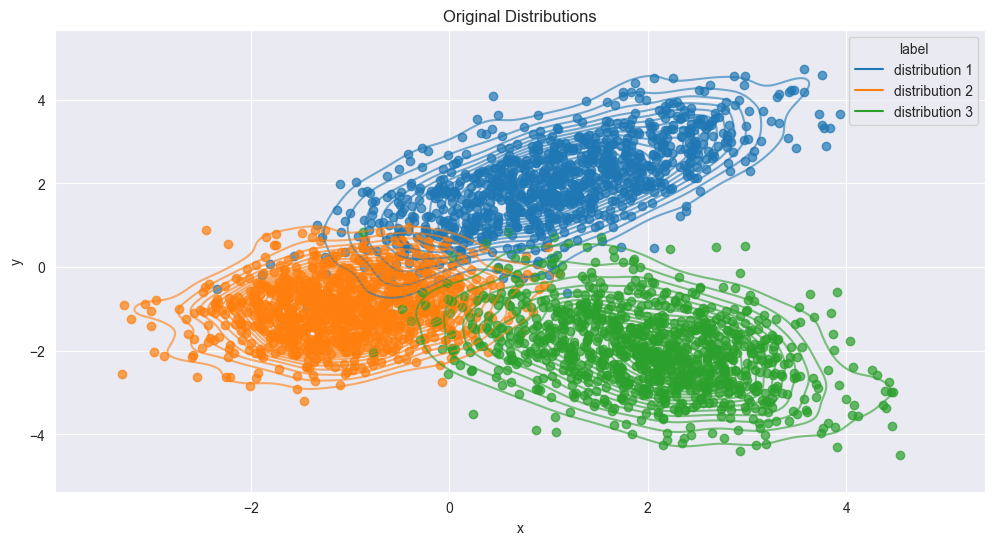

In [4]:
plt.figure(figsize=(12, 6))

plt.scatter(data1[:, 0], data1[:, 1], alpha=0.7)
plt.scatter(data2[:, 0], data2[:, 1], alpha=0.7)
plt.scatter(data3[:, 0], data3[:, 1], alpha=0.7)

df1 = pd.DataFrame(data1, columns = ['x', 'y'])
df2 = pd.DataFrame(data2, columns = ['x', 'y'])
df3 = pd.DataFrame(data3, columns = ['x', 'y'])

df1['label'] = "distribution 1"
df2['label'] = "distribution 2"
df3['label'] = "distribution 3"

data = pd.concat([df1, df2, df3], ignore_index = True)

sns.kdeplot(data, x='x', y='y', hue='label', levels=20, alpha=0.6)

plt.title("Original Distributions")
plt.show();

### Problem Definition

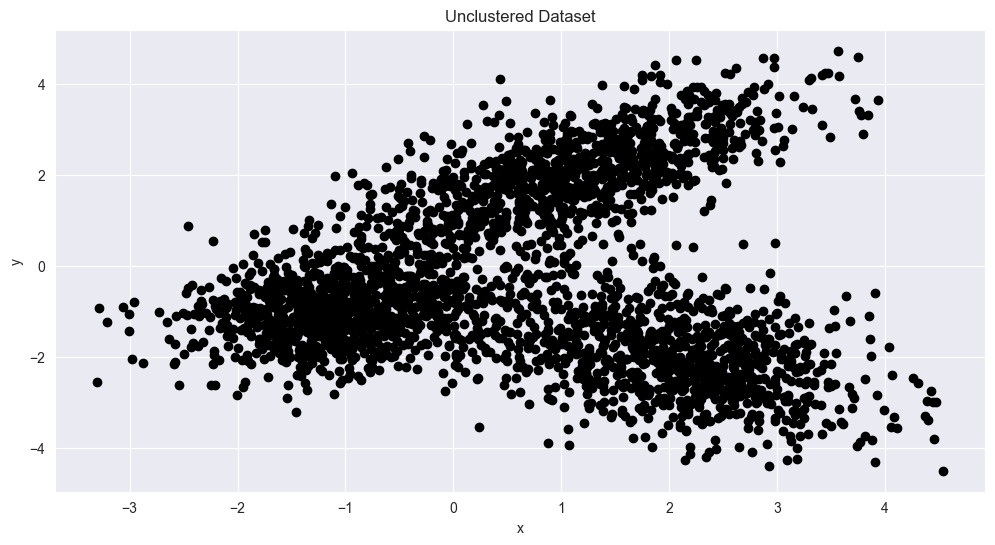

In [5]:
X = np.concatenate((data1, data2, data3))
np.random.shuffle(X)

plt.figure(figsize=(12, 6))

plt.scatter(X[:, 0], X[:, 1], color='black')
plt.title("Unclustered Dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.show();

### Initialization

In [6]:
def random_init(X, dim, n_components):
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, n_components, replace=True)
    
    means = X[indices]
    covmats = np.array([np.eye(dim) for _ in range(n_components)])
    pi = np.ones((n_components))/n_components
    
    return means, covmats, pi

### Expectation Step

In [7]:
def expectation(X, n_components, means, covmats, pi):
    n_samples = X.shape[0]
    weights = np.zeros((n_components, n_samples))
    
    for i in range(n_samples):
        for j in range(n_components):
            weights[j, i] = pi[j] * multivariate_normal.pdf(X[i], mean=means[j], cov=covmats[j])
        weights[:, i] /= np.sum(weights[:, i])
        
    return weights

### Maximization Step

In [8]:
def maximize(X, weights, n_components, dim, means, covmats, pi):
    pis = np.mean(weights, axis=1)
    
    covmats = np.zeros((n_components, dim, dim))
    for j in range(n_components):
        means[j]   = np.sum(weights[j, :, np.newaxis] * X, axis=0) / np.sum(weights[j])
        diff = X - means[j]
        covmats[j] = ((weights[j, :, np.newaxis] * diff).T @ diff) / np.sum(weights[j])
        
    return means, covmats, pi

In [9]:
def plot_intermediate(X, means, covmats, step):
    plt.figure(figsize=(12, 6))

    plt.scatter(X[:, 0], X[:, 1], color='black', alpha=0.5)

    plot_samples = pd.DataFrame()
    for j, i in enumerate(["distribution 1", "distribution 2", "distribution 3"]):
        cluster_data = np.random.multivariate_normal(means[j], covmats[j], X.shape[0])
        df = pd.DataFrame(cluster_data, columns = ['x', 'y'])
        df['label'] = i
        plot_samples = pd.concat([plot_samples, df], ignore_index=True)
    
    sns.kdeplot(plot_samples, x='x', y='y', hue='label', alpha=0.8)

    plt.title(f"GMM fit - step {step}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show();

### Training

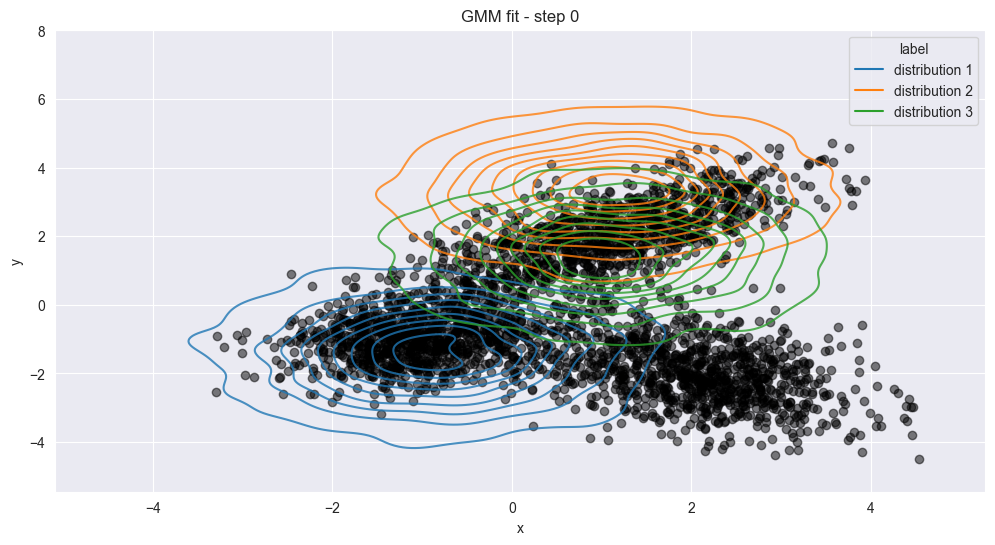

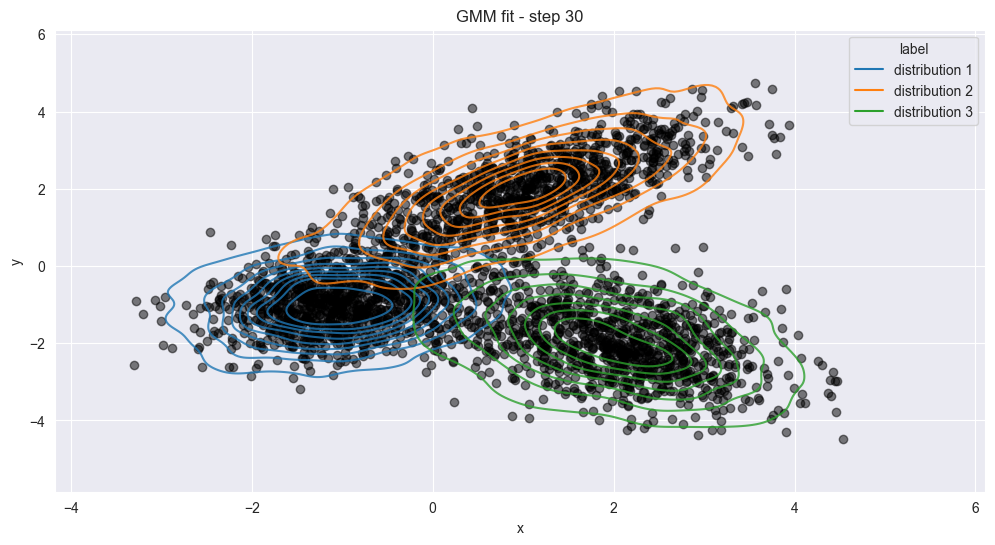

In [10]:
dim = X.shape[1]
n_components = 3
n_steps = 30

means, covmats, pi = random_init(X, dim, n_components)

plot_intermediate(X, means, covmats, 0)

for i in range(n_steps):
    weights = expectation(X, n_components, means, covmats, pi)
    means, covmats, pi = maximize(X, weights, n_components, dim, means, covmats, pi)

plot_intermediate(X, means, covmats, 30)